# Scrape Source Texts from Wikipedia

In [ ]:
# ! pip install wikipedia

In [54]:
import wikipedia
import re
import urllib.request
import time
import json

with urllib.request.urlopen('https://simple.wikipedia.org/wiki/List_of_countries') as f:
    scraped = f.read(1000000)

countries = re.findall(r'<a.*?title="(.*?)">.*?<\/a>', scraped.decode('utf-8'))
start = countries.index('Afghanistan')
end_incl = countries.index('Zimbabwe')
countries = countries[start: end_incl+1]

excluded_data = ['Change section']
def is_excluded(country):
    return any(e in country for e in excluded_data)

countries = [country for country in countries 
             if not is_excluded(country)] 


def wiki_download(name):
    text = wikipedia.page(name, redirect=False, auto_suggest=False).content
    text = re.sub(r'==.*?==+', '', text)
    text = text.replace('\n\n\n', '\n')
    return text

texts = []
for i, country in enumerate(countries):
    text = wiki_download(country)
    custom_sep = ', ' if i > 0 else ''
    print(custom_sep + country, end='')
    texts.append(text.strip().split(' '))
    
with open('texts.json', 'wt') as f:
    json.dump(texts, f, ensure_ascii=False)

Afghanistan, Albania, Algeria, Andorra, Angola, Antigua and Barbuda, Argentina, Armenia, Australia, Austria, Azerbaijan, The Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belgium, Belize, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Brunei, Bulgaria, Burkina Faso, Burundi, Cambodia, Cameroon, Canada, Cape Verde, Central African Republic, Chad, Chile, China, Colombia, Comoros, Democratic Republic of the Congo, Republic of the Congo, Costa Rica, Croatia, Cuba, Cyprus, Czech Republic, Danish Realm, Djibouti, Dominica, Dominican Republic, East Timor, Ecuador, Egypt, El Salvador, Equatorial Guinea, Eritrea, Estonia, Eswatini, Ethiopia, Fiji, Finland, France, Gabon, The Gambia, Georgia (country), Germany, Ghana, Greece, Grenada, Guatemala, Guinea, Guinea-Bissau, Guyana, Haiti, Honduras, Hungary, Iceland, India, Indonesia, Iran, Iraq, Republic of Ireland, Israel, Italy, Ivory Coast, Jamaica, Japan, Jordan, Kazakhstan, Kenya, Kiribati, North Korea, South Korea, Kuwait, 

# Generate some images

- all scans need to have the same resolution (upscaling/downscaling)
- potential extension: extracting numbers from tables
- line breaks

In [120]:
from PIL import Image, ImageDraw, ImageFont
import math
import random
from typing import Union, Tuple
from pathlib import Path
import numpy as np

RNG = np.random.default_rng()
COLOR = (250, 250, 250)

class GenerateImage:
    def __init__(self, text_split, width = 800, ratio = 2 ** 0.5) -> None:
        self.text_split = text_split
        self.width = width
        self.height = int(width * ratio)
        self.image = Image.new('RGB', size=(width, self.height), color=COLOR)  # A4
        self.draw = ImageDraw.Draw(self.image)
        self.font = ImageFont.truetype('fonts/Roboto-Regular', 13)
        self.font_families = self.get_fonts()
        self.font_variants = 'Regular Italic Bold BoldItalic'.split()
        
    def get_fonts(self):
        """ Get unique names of fonts in the font library 
        (w/o regular/italic/bold/bolditalic variants """
        # wrapped in list since sets (unlike dicts as from python 3.7) are not guaranteed
        # to be stable and we need to index font families (while choosing at random)
        return list({entry.name.split('-')[0] 
                    for entry in Path('fonts').iterdir() if entry.is_file()})

    def get_block_coordinates(self):
        block_width_fraction = 0.3 + RNG.random() * 0.4
        block_width = int(self.width * block_width_fraction)

        block_height_fraction = 0.2 + RNG.random() * 0.4
        block_height = int(self.height * block_height_fraction)

        remaining_width = self.width - block_width
        remaining_height = self.height - block_height

        margin_xy = int(0.05 * min(block_width, block_height))
        x_pos = RNG.integers(margin_xy, remaining_width, endpoint=True)
        y_pos = RNG.integers(margin_xy, remaining_height, endpoint=True)
        
        return [(x_pos, y_pos), (x_pos+block_width, y_pos+block_height)]
    
    def get_words_idx(self, start_idx: int, block_width: int) -> Union[int, None]:
        """ Finds a span of words from self.text_split that just fits block_width
        Args:
            start_idx: first word from self.text_split (inclusive)
            block_width: width of line for typesetting words in pixels
        Returns:
            index of the last word from self.text_split (exclusive)
        """
        success_end_idx = None
        for end_idx in range(start_idx + 1, len(self.text_split) + 1):
            sub_text = ' '.join(self.text_split[start_idx: end_idx])
            text_width = self.draw.textlength(sub_text, font=self.font)
            if text_width > block_width:
                break
            else:
                success_end_idx = end_idx
        if success_end_idx is None:
            return None
        else:
            return success_end_idx
            
    def print_block(self):
        (x0, y0), (x1, y1) = self.get_block_coordinates()
        # self.draw.rectangle([(x0, y0), (x1, y1)], fill=(200, 200, 200))  # type: ignore
        block_width = x1 - x0 + 1
        block_height = y1 - y0 + 1
        
        broken_text_prev, broken_text = None, ''
        start_idx = 0
        
        while True:
            end_idx = self.get_words_idx(start_idx, block_width)
            if end_idx is None:
                break
            divider = '' if broken_text == '' else '\n'
            broken_text_prev = broken_text
            broken_text += divider + ' '.join(self.text_split[start_idx: end_idx])
            start_idx = end_idx
            
            bx0, by0, bx1, by1 = self.draw.textbbox((x0, y0), broken_text, 
                                                         font=self.font, spacing=4)
            
            if (by1 - by0 + 1) > block_height:
                broken_text = broken_text_prev
                break
        
        if broken_text is not None:
            self.draw.multiline_text((x0, y0), broken_text, 
                                     font=self.font, spacing=4, fill=(40, 40, 40))
        
        return self
    
    def save_image(self, path):
        self.image.save(path)
        
    def __
        

img_index = 1
path = Path('..') / 'images' / f'img{img_index:04d}.jpg'
GenerateImage(text_split).print_block().save_image(path)

# Blur Rotate ... Image

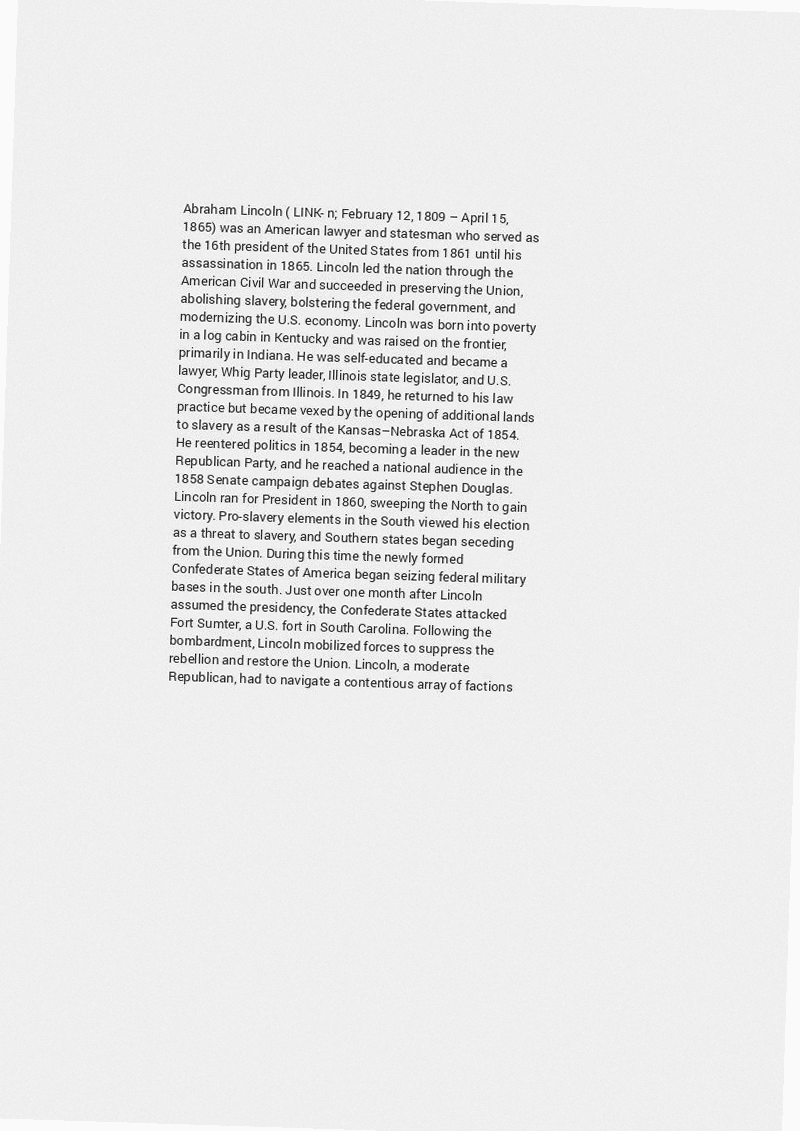

In [140]:
from PIL import ImageFilter

def process_img(number, blur, noise, contrast, offset, rotate):
    inpath = Path('..') / 'images' / f'img{number:04d}.jpg'
    outpath = Path('..') / 'images' / f'out{number:04d}.jpg'
    image = Image.open(inpath).filter(ImageFilter.GaussianBlur(radius=blur))
    noise = Image.effect_noise(image.size, noise)
    noise_arr = np.asarray(noise).astype(float)[:, :, None] - 128
    image_arr = np.asarray(image).astype(float)
    image_arr = (image_arr * contrast) + offset
    res_arr = (noise_arr + image_arr).clip(0, 255)
    res_img = Image.fromarray(res_arr.astype(np.uint8))
    res_img = res_img.rotate(rotate, 
                            fillcolor=COLOR,
                            resample=Image.Resampling.BICUBIC)  # type: ignore
    res_img.save(outpath)
    return res_img


r = process_img(
    number=1,
    blur=RNG.uniform(0, 0.3),
    noise=RNG.uniform(1,5),
    contrast=RNG.uniform(0.95, 1.05),
    offset=RNG.uniform(-10,10),
    rotate=RNG.uniform(-2,2)
)

display(r)

In [ ]:
API_KEY = 'K88811114388957'
